In [199]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init


import matplotlib
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax


###
from sklearn.metrics import accuracy_score
from numpy import savez_compressed
import random
from numpy import load
from sklearn.metrics import roc_auc_score
import sklearn.metrics as metrics

%matplotlib inline

In [ ]:
data_dir = "/Users/alsj/Documents/Courses/Deep_Learning/dl_project"

In [ ]:
# alphabet
alphabet_file = data_dir + "/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)

In [ ]:
# blossum encoding
blosum_file = data_dir + "/blosum50_2_no_B_Z_copy"

_blosum50 = np.loadtxt(blosum_file, dtype=float).reshape((22, -1)).T

blosum50 = {}

for i, letter_1 in enumerate(alphabet):
    
    blosum50[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        blosum50[letter_1][letter_2] = _blosum50[i, j] / 5.0

In [ ]:
# peptide encoding
def encode(peptides, encoding_scheme, alphabet):
    
    encoded_peptides = []

    for peptide in peptides:

        encoded_peptide = []

        for peptide_letter in peptide:

            for alphabet_letter in alphabet:

                encoded_peptide.append(encoding_scheme[peptide_letter][alphabet_letter])
        
        # store peptide
        encoded_peptides.append(encoded_peptide)
        
    return np.array(encoded_peptides)

In [ ]:

def padding(nnt, num_pad, m_dict):
    x = []
    
  #  for d in range(0,len(nnt)):
    for n, i in enumerate(nnt[0]):
        if len(i) != num_pad:

            if (len(i) % 2) == 0:
                split_sec = len(i)//2

                n_t_p = num_pad - len(i)

                x_s = "X"*n_t_p

                left = i[:split_sec]+x_s
                right = i[split_sec:]

                #print(left+right)
                #print(len(left+right))

                #nnt[n] = left+right+m_dict[nnt[2][n]]
                x.append(left+right+m_dict[nnt[2][n]])


            else:
                split_sec = len(i)//2
                n_t_p = num_pad - len(i)
                x_s = "X"*n_t_p

                #binomial statement
                result = np.random.binomial(1, 0.5)
                if result == 1:

                    left = i[:split_sec] + x_s
                    right = i[split_sec:]

                    #nnt[n] = left+right+m_dict[nnt[2][n]]
                    x.append(left+right+m_dict[nnt[2][n]])

                else:

                    left = i[:split_sec+1] + x_s
                    right = i[split_sec+1:]

                    #nnt[n] = left+right+m_dict[nnt[2][n]]
                    x.append(left+right+m_dict[nnt[2][n]])

        else:
            x.append(i+m_dict[nnt[2][n]])
            
    return x






In [ ]:
# load data

el_data_mhc = data_dir + "/el_data/MHC_pseudo.dat"
mhc_dat = np.loadtxt(el_data_mhc, dtype=str)

el_data_00 = data_dir + "/el_data/c000_el"
el_data_01 = data_dir + "/el_data/c001_el"
el_data_02 = data_dir + "/el_data/c002_el"
el_data_03 = data_dir + "/el_data/c003_el"
el_data_04 = data_dir + "/el_data/c004_el"

file_00_c = pd.read_csv(el_data_00, sep = " ", header=None)
file_01_c = pd.read_csv(el_data_01, sep = " ", header=None)
file_02_c = pd.read_csv(el_data_02, sep = " ", header=None)
file_03_c = pd.read_csv(el_data_03, sep = " ", header=None)
file_04_c = pd.read_csv(el_data_04, sep = " ", header=None)

In [ ]:
# create mhc seq dictionary

mhc_dict = {}
for mhc in mhc_dat:
    mhc_dict[mhc[0]] = mhc[1]

In [ ]:
# creating training data file

training_data = pd.concat([file_01_c,file_02_c,file_03_c,file_04_c], ignore_index=True)

# training_data[0] = training_data[0].str.upper()

file_01_c[0] = file_01_c[0].str.upper() #make sure that all amino acids are uppercase

file_02_c[0] = file_02_c[0].str.upper() #make sure that all amino acids are uppercase

file_03_c[0] = file_03_c[0].str.upper() #make sure that all amino acids are uppercase

file_04_c[0] = file_04_c[0].str.upper() #make sure that all amino acids are uppercase

valid_data = file_00_c.copy(deep=True)


valid_data[0] = valid_data[0].str.upper()


# finding the longest sequence in the dataset

pad_num = training_data[0].str.len().max()
print(pad_num)

In [ ]:
# target data
savez_compressed('target1.npz', file_01_c[1])
savez_compressed('target2.npz', file_02_c[1])
savez_compressed('target3.npz', file_03_c[1])
savez_compressed('target4.npz', file_04_c[1])

In [ ]:
train_1 =  encode(padding(file_01_c, pad_num, mhc_dict), blosum50, alphabet)
savez_compressed('data1.npz', train_1)

In [ ]:
train_2 =  encode(padding(file_02_c, pad_num, mhc_dict), blosum50, alphabet)
savez_compressed('data2.npz', train_2)

In [ ]:
train_3 =  encode(padding(file_03_c, pad_num, mhc_dict), blosum50, alphabet)
savez_compressed('data3.npz', train_3)

In [ ]:
train_4 =  encode(padding(file_04_c, pad_num, mhc_dict), blosum50, alphabet)
savez_compressed('data4.npz', train_4)

In [184]:
# loading validation data/test data

dict_data0 = load('data0.npz')
x_valid = dict_data0['arr_0']

dict_data_v = load('targets_valid.npz')
targets_valid = dict_data_v['arr_0']

In [195]:
# define network
class Net(nn.Module):

    def __init__(self, input_dim, hidden_dim, NUM_CLASSES):
        super(Net, self).__init__()  
        
        self.l_1 = nn.Linear(input_dim, hidden_dim) 

        self.l_out = nn.Linear(hidden_dim, NUM_CLASSES)  
        
    def forward(self, x):
        # 
        x = relu(self.l_1(x))
        
        out = sigmoid(self.l_out(x))
        
        return out
        


#Hyperparameters
num_input = (14+34)*22
num_hidden = 100
num_classes = 1


net = Net(num_input, num_hidden, num_classes)



if torch.cuda.is_available():
    net.cuda()
print(net)
    








Net(
  (l_1): Linear(in_features=1056, out_features=100, bias=True)
  (l_out): Linear(in_features=100, out_features=1, bias=True)
)


In [196]:
# Building the cost function.

LEARNING_RATE = 2e-5

criterion =     nn.BCELoss()

optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)






In [197]:
target_data_dict = {"data1.npz":'target1.npz', "data2.npz":'target2.npz', "data3.npz":'target3.npz', "data4.npz":'target4.npz'}



target_data_dict

{'data1.npz': 'target1.npz',
 'data2.npz': 'target2.npz',
 'data3.npz': 'target3.npz',
 'data4.npz': 'target4.npz'}

/Users/alsj/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:1350: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/Users/alsj/anaconda3/lib/python3.7/site-packages/torch/nn/modules/loss.py:498: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])) is deprecated. Please ensure they have the same size.
  return F.binary_cross_entropy(input, target, weight=self.weight, reduction=self.reduction)


Epoch  1 : Train Loss 10.435822 , Train acc 0.954631, Valid acc 0.954270
Epoch  2 : Train Loss 9.308748 , Train acc 0.956500, Valid acc 0.955655
Epoch  3 : Train Loss 8.656812 , Train acc 0.958501, Valid acc 0.957482
Epoch  4 : Train Loss 8.185974 , Train acc 0.959661, Valid acc 0.959224
Epoch  5 : Train Loss 7.465378 , Train acc 0.964245, Valid acc 0.963696
Epoch  6 : Train Loss 6.659836 , Train acc 0.965320, Valid acc 0.964386
Epoch  7 : Train Loss 6.237753 , Train acc 0.969300, Valid acc 0.968462
Epoch  8 : Train Loss 5.986631 , Train acc 0.967945, Valid acc 0.967142
Epoch  9 : Train Loss 5.781336 , Train acc 0.968879, Valid acc 0.968043
Epoch 10 : Train Loss 5.793941 , Train acc 0.971075, Valid acc 0.970658
Epoch 11 : Train Loss 5.497559 , Train acc 0.970339, Valid acc 0.969570
Epoch 12 : Train Loss 5.573678 , Train acc 0.971018, Valid acc 0.970766
Epoch 13 : Train Loss 5.294858 , Train acc 0.973609, Valid acc 0.972718
Epoch 14 : Train Loss 5.404811 , Train acc 0.973483, Valid acc 

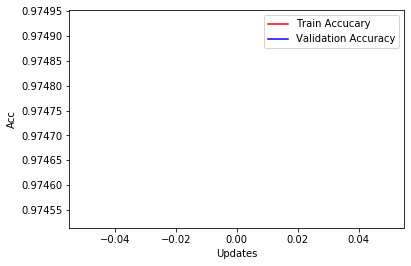

In [ ]:
num_epochs = 20
batch_size = 128
ev_batch_size = 64

train_list = ["data1.npz", "data2.npz", "data3.npz", "data4.npz"]

num_samples_valid = x_valid.shape[0] 
num_batches_valid = num_samples_valid // ev_batch_size 

train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
cur_loss = 0
losses = []

##

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    
    # setting up lists for handling loss/accuracy

    train_acc, train_loss = [], [] 
    valid_acc, valid_loss = [], [] 
    
    random.shuffle(train_list)
    
    for num, data_f in enumerate(train_list):
        dict_data = load(data_f)
        x_train = dict_data['arr_0']
        
        dict_data_target = load(target_data_dict[data_f])
        targets_train = dict_data_target['arr_0']
        # batch setup and accuracy

        num_samples_train = x_train.shape[0] 
        num_batches_train = num_samples_train // batch_size 

        ## Train
        cur_loss = 0
        net.train()
        losses = []
        for i in range(num_batches_train):
            slce = get_slice(i, batch_size)

            x_batch = torch.tensor(x_train[slce], dtype = torch.float, requires_grad = True) 
            output = net(x_batch)

            target_batch = torch.tensor(np.array(targets_train)[slce], dtype = torch.float)
            batch_loss = criterion(output, target_batch)
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

            cur_loss += batch_loss   
        losses.append(cur_loss / batch_size)
        
        

    net.eval()
    ### Evaluate training
    
    train_preds, train_targs = [], [] 
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        
        x_batch = torch.tensor(x_train[slce], dtype = torch.float) 

        output = net(x_batch)
        preds = np.round(output.detach())


        train_targs += list(np.array(targets_train)[slce])
        train_preds += list(preds.data.numpy())


    ### Evaluate validation

    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, ev_batch_size)
    
        x_batch = torch.tensor(x_valid[slce], dtype = torch.float)

        output = net(x_batch)
        
        preds = np.round(output.detach())
        val_preds += list(preds.data.numpy()) 
        val_targs += list(np.array(targets_valid)[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)  
    valid_acc_cur = accuracy_score(val_targs, val_preds)      




    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)


    train_targs_e = 'epoch_%03d_train_targs_e.npz' %epoch
    savez_compressed(train_targs_e, train_targs)

    train_preds_e = 'epoch_%03d_train_preds_e.npz' %epoch
    savez_compressed(train_preds_e, train_preds)
    
    val_targs_e = 'epoch_%03d_val_targs_e.npz' %epoch
    savez_compressed(val_targs_e, val_targs)

    val_preds_e = 'epoch_%03d_val_preds_e.npz' %epoch
    savez_compressed(val_preds_e, val_preds)

    
    train_acc_name = 'epoch_%03d_train_acc.npz' %epoch
    savez_compressed(train_acc_name, train_acc)


    valid_acc_name = 'epoch_%03d_valid_acc.npz' %epoch
    savez_compressed(valid_acc_name, valid_acc)


    


    #if epoch % 10 == 0:
    print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

    

    
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')



## Accuracy graph

In [200]:
#test = 'epoch_%03d_test.npz' %epoch
#savez_compressed(test, train_acc)
valid_acc = []#np.empty([1,5])
for epoch in range(20):
    dict_n = load('epoch_%03d_valid_acc.npz' %epoch)
    targets_n = dict_n['arr_0']
    valid_acc.append(targets_n)
    

In [201]:
#test = 'epoch_%03d_test.npz' %epoch
#savez_compressed(test, train_acc)
train_acc = []#np.empty([1,5])
for epoch in range(20):
    dict_n = load('epoch_%03d_train_acc.npz' %epoch)
    targets_n = dict_n['arr_0']
    train_acc.append(targets_n)
    

(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

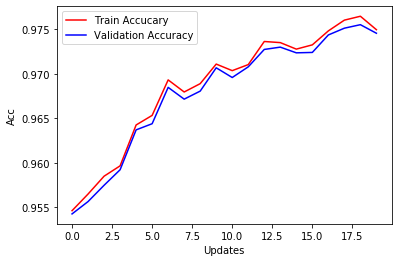

In [202]:
epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')




## AUC

In [203]:
val_targs = []
for epoch in range(20):
    dict_n = load('epoch_%03d_val_targs_e.npz' %epoch)
    targets_n = dict_n['arr_0']
    #np.append(train_preds, targets_n)
    val_targs = np.array(targets_n)


val_preds = []
for epoch in range(20):
    dict_n = load('epoch_%03d_val_preds_e.npz' %epoch)
    targets_n = dict_n['arr_0']
    #np.append(train_preds, targets_n)
    val_preds = np.array(targets_n)
    
#val_targs

In [204]:
train_targs = []
for epoch in range(20):
    dict_n = load('epoch_%03d_train_targs_e.npz' %epoch)
    targets_n = dict_n['arr_0']
    #np.append(train_preds, targets_n)
    train_targs = np.array(targets_n)


train_preds = []
for epoch in range(20):
    dict_n = load('epoch_%03d_train_preds_e.npz' %epoch)
    targets_n = dict_n['arr_0']
    #np.append(train_preds, targets_n)
    train_preds = np.array(targets_n)
    

In [205]:
train_auc = roc_auc_score(train_targs, train_preds)  
valid_auc = roc_auc_score(val_targs, val_preds)
print("train auc ", train_auc)
print("valid auc ",valid_auc)

train auc  0.7722576224305129
valid auc  0.7672701432952433


## ROC

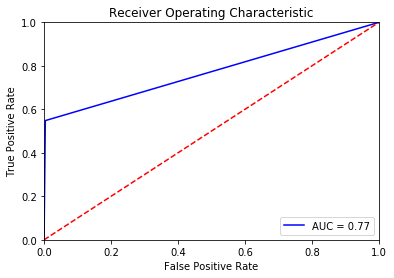

In [208]:
fpr, tpr, threshold = metrics.roc_curve(train_targs, train_preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

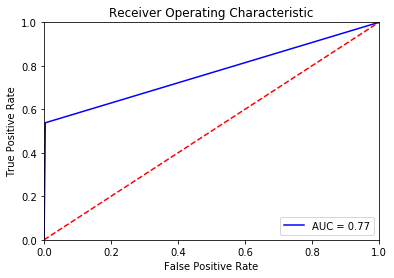

In [213]:
fpr, tpr, threshold = metrics.roc_curve(val_targs, val_preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()